# Import Libraries

In [ ]:
pip install -q phonenumbers

In [ ]:
# Snowpark for Python
from snowflake.snowpark import Session
from snowflake.snowpark.version import VERSION
import snowflake.snowpark.functions as F
from snowflake.snowpark.types import DecimalType

# Snowpark ML
import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.metrics.correlation import correlation

# Data Science Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Misc
import json
import joblib

# warning suppresion
import warnings; warnings.simplefilter('ignore')

import phonenumbers

In [ ]:
# Make a Snowpark Connection


connection_parameters = json.load(open('connection.json'))
session = Session.builder.configs(connection_parameters).create()
session.sql_simplifier_enabled = True

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

In [ ]:
# Specify the table name where we stored the diamonds dataset
# **nChange this only if you named your table something else in the data ingest notebook **
CONVERTEDONLY_LEADS_TABLE = 'CONVERTEDONLY'
input_tbl = f"{session.get_current_database()}.{session.get_current_schema()}.{CONVERTEDONLY_LEADS_TABLE}"

In [ ]:
# First, we read in the data from a Snowflake table into a Snowpark DataFrame
leads_df = session.table(input_tbl)

In [ ]:
leads_df = leads_df.drop('SALUTATION'
,'TITLE'
,'FIRSTNAME'
,'LASTNAME'
,'CONVERTEDCONTACTID'
,'CONVERTEDDATE'
,'CONVERTEDCONTACTID'
,'CONVERTEDORGANIZATIONID'
,'UPDATEDDATE'
,'EMPLOYEECOUNT'
,'LEADRATING'
,'FAX'
,'INDUSTRY'
,'OWNERUSERID'
,'RESPONSIBLEUSERID'
,'ADDRESSSTREET'
,'ADDRESSCITY'
,'ADDRESSSTATE'
,'ADDRESSPOSTCODE'
,'LASTACTIVITYDATE'
,'NEXTACTIVITYDATE'
,'VISIBLETO'
,'VISIBLETEAMID'
,'ORGANIZATIONNAME'
,'CREATEDUSERID'
,'IMAGEURL'
,'TAGS'
,'O_ID'
, 'CONVERTED'
, 'CONVERTEDOPPORTUNITYID')


In [ ]:
# Checking for missing values in the leads_df EMAIL dataframe column
leads_df = leads_df.na.replace('', "unknown@unknown.nl", subset='EMAIL')
leads_df.write.mode('overwrite').save_as_table('tmp_leadsonly')

In [ ]:
# Creating a new column 'LENGTH_LEADDESCRIPTION' indicating the length of the text in 'LEADDESCRIPTION'
leads_df = leads_df.withColumn("LENGTH_LEADDESCRIPTION", F.length(F.col("LEADDESCRIPTION")))
leads_df = leads_df.drop('LEADDESCRIPTION')
leads_df.write.mode('overwrite').save_as_table('tmp_leadsonly')


In [ ]:
# List of identified private email domains
private_domains = [
    'gmail.com', 'hotmail.com', 'orange.fr', 'wanadoo.fr', 'hotmail.fr',
    'yahoo.com', 'outlook.com', 'hotmail.co.uk', 'me.com', 'gmx.de',
    'icloud.com', 'yahoo.it', 'libero.it', 'web.de', 'kpnmail.nl',
    'yahoo.de', 'yahoo.fr', 'free.fr', 'telenet.be', 'live.fr',
    'otenet.gr', 'mac.com', 'yahoo.co.uk', 'laposte.net', 'uol.com.br',
    'casema.nl', 'aol.com', 't-online.de', 'unknown.com', 'yahoo.in',
    'gmx.fr', 'mail.com', 'mail.ru', 'live.it', 'msn.com',
    'yahoo.com.sg', 'hotmail.it', 'googlemail.com', 'hotmail.nl', 'ziggo.nl'
]

# Extracting the domain from the 'Email' column
leads_df = leads_df.withColumn(
    "Email_Domain",
    F.regexp_extract(F.col("Email"), '@([a-zA-Z0-9.-]+)$', 1)
)
leads_df.write.mode('overwrite').save_as_table('tmp_leadsonly')


In [ ]:
# Classifying the email addresses as 'Private' or 'Business'
# merged_data_prefixed['c_Email_Type'] = merged_data_prefixed['c_Email_Domain'].apply(
#     lambda x: 'Private' if x in private_domains else 'Business')

# Creating a column to classify email as 'Private' or 'Business'
leads_df = leads_df.withColumn(
    "Email_Type",
    F.when(F.col("Email_Domain").isin(private_domains), "Private").otherwise("Business")
)
leads_df.write.mode('overwrite').save_as_table('tmp_leadsonly')

In [ ]:
leads_df = leads_df.drop('EMAIL_DOMAIN')
leads_df.write.mode('overwrite').save_as_table('tmp_leadsonly')

In [ ]:
leads_df = leads_df.drop('WEBSITE')
leads_df.write.mode('overwrite').save_as_table('TMP_LEADSONLY')

In [ ]:
# Creating a new column 'PHONENUMBER' based on 'MOBILE' and 'PHONE'
leads_df = leads_df.withColumn(
    "PHONENUMBER",
    F.when(F.col("MOBILE").isNull() | (F.col("MOBILE") == ''), F.col("PHONE")).otherwise(F.col("MOBILE"))
)
leads_df.write.mode('overwrite').save_as_table('TMP_LEADSONLY')

In [ ]:
def get_country_code(phone_number):
    try:
        parsed_number = phonenumbers.parse(phone_number, None)
        if phonenumbers.is_valid_number(parsed_number):
            return '+' + str(parsed_number.country_code)
        else:
            return "Invalid number: " + phone_number
    except Exception as e:
        return "Error parsing: " + str(e)

# Test the function with your sample numbers
sample_numbers = [
    "+49 221 64304440227",
    "+49 173 6240149",
    "0049 1719505613"
]

for number in sample_numbers:
    print(get_country_code(number))

In [ ]:
# Creating a new column 'COUNTRYCODE' based on 'PHONENUMBER'

def get_country_code(phone_number):
    # return phn.parse(phone_number, None)
    try:
        parsed_number = phonenumbers.parse(phone_number, None)
        if phonenumbers.is_valid_number(parsed_number):
            return '+' + str(parsed_number.country_code)
    except:
        pass
    return '+00'

# Assuming leads_df is your Snowflake DataFrame
leads_df_pandas = leads_df.to_pandas()

leads_df_pandas['COUNTRYCODE'] = leads_df_pandas['PHONENUMBER'].apply(
    lambda x: get_country_code(str(x)) if pd.notna(x) else '+00'
)

session.write_pandas(leads_df_pandas, "TEMP_LEADS_TABLE", auto_create_table=True)

# Read the data back into a Snowflake DataFrame
leads_df_snowflake = session.table("TEMP_LEADS_TABLE")

# Write the Snowflake DataFrame to a permanent table
leads_df_snowflake.write.mode("overwrite").save_as_table("TMP_LEADSONLY")


In [ ]:
# Checking for missing values in the leads_df EMAIL dataframe column
leads_df_snowflake = leads_df_snowflake.na.replace('', "Netherlands", subset='ADDRESSCOUNTRY')
leads_df_snowflake = leads_df_snowflake.na.replace('-', "Netherlands", subset='ADDRESSCOUNTRY')
leads_df_snowflake.write.mode('overwrite').save_as_table('TMP_LEADSONLY')

In [ ]:
leads_df_snowflake = leads_df_snowflake.drop('MOBILE', 'PHONE', 'PHONENUMBER', 'LEADSTATUSID', 'EMAIL', 'COUNTRYCODE', 'CUSTOMFIELDS', 'CREATEDYEAR', 'CREATEDDATE')
leads_df_snowflake.write.mode('overwrite').save_as_table('TMP_LEADSONLY')


In [ ]:
# Splitting 'CreatedDate' into Year, Month, Week, Day, and Hour portions with specified format

# Assuming leads_df is your Snowflake DataFrame and 'CreatedDate' is a column in this DataFrame

# Extracting year, month, week, day, and hour from 'CreatedDate'
# Convert 'CreatedDate' to a timestamp type with the specified format
leads_df_snowflake = leads_df_snowflake.withColumn('CreatedDate', F.to_timestamp('CreatedDate', 'MM/DD/YYYY HH12:MI:SS AM'))
leads_df_snowflake = leads_df_snowflake.withColumn('CreatedYear', F.year('CreatedDate'))
leads_df_snowflake = leads_df_snowflake.withColumn('CreatedMonth', F.month('CreatedDate'))
leads_df_snowflake = leads_df_snowflake.withColumn('CreatedWeek', F.weekofyear('CreatedDate'))
leads_df_snowflake = leads_df_snowflake.withColumn('CreatedDay', F.dayofweek('CreatedDate'))  # Note: In Snowflake, Sunday=0, Saturday=6
leads_df_snowflake = leads_df_snowflake.withColumn('CreatedHour', F.hour('CreatedDate'))

# Adjust 'CreatedDay' to make Monday=1, Sunday=7 if needed
# leads_df = leads_df.withColumn('CreatedDay', (F.col('CreatedDay') % 7) + 1)
# leads_df.write.mode('overwrite').save_as_table('tmp_leadsonly')
leads_df_snowflake.show()



In [ ]:
leads_df_snowflake.write.mode('overwrite').save_as_table('TMP_LEADSONLY')

In [35]:
leads_df_snowflake.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ID"      |"LEADSOURCEID"  |"ADDRESSCOUNTRY"  |"O_OPPORTUNITYSTATE"  |"LENGTH_LEADDESCRIPTION"  |"EMAIL_TYPE"  |"CREATEDMONTH"  |"CREATEDWEEK"  |"CREATEDDAY"  |"CREATEDHOUR"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|45435089  |2973396         |Netherlands       |0                     |0                         |Business      |9               |37             |3             |13             |
|45435129  |2985683         |Germany           |0                     |80                        |Business      |9               |37             |3             |13             |
|45435158  |2985683         |Germany           |0                     |244                       |Business    

In [36]:
# Encode categoricals to numeric columns
snowml_ohe = snowml.OneHotEncoder(input_cols=["LEADSOURCEID", "ADDRESSCOUNTRY", "EMAIL_TYPE"], output_cols=["LEADSOURCEID_OHE", "ADDRESSCOUNTRY_OHE", "EMAILTYPE_OHE"])
transformed_leads_df = snowml_ohe.fit(leads_df_snowflake).transform(leads_df_snowflake)

np.array(transformed_leads_df.columns)

array(['LEADSOURCEID_OHE_2973396', 'LEADSOURCEID_OHE_2973397',
       'LEADSOURCEID_OHE_2973398', 'LEADSOURCEID_OHE_2985683',
       'LEADSOURCEID_OHE_2985685', 'LEADSOURCEID_OHE_3306719',
       'LEADSOURCEID_OHE_3306720', 'LEADSOURCEID_OHE_3314817',
       'LEADSOURCEID_OHE_3367610', '"ADDRESSCOUNTRY_OHE_Armenia"',
       '"ADDRESSCOUNTRY_OHE_Austria"', '"ADDRESSCOUNTRY_OHE_Bangladesh"',
       '"ADDRESSCOUNTRY_OHE_Belgium"',
       '"ADDRESSCOUNTRY_OHE_Bosnia And Herzegowina"',
       '"ADDRESSCOUNTRY_OHE_Brazil"', '"ADDRESSCOUNTRY_OHE_Bulgaria"',
       '"ADDRESSCOUNTRY_OHE_Cote D\'ivoire"',
       '"ADDRESSCOUNTRY_OHE_Croatia"', '"ADDRESSCOUNTRY_OHE_Cyprus"',
       '"ADDRESSCOUNTRY_OHE_Czech Republic"',
       '"ADDRESSCOUNTRY_OHE_Denmark"', '"ADDRESSCOUNTRY_OHE_Egypt"',
       '"ADDRESSCOUNTRY_OHE_Estonia"', '"ADDRESSCOUNTRY_OHE_France"',
       '"ADDRESSCOUNTRY_OHE_Gambia"', '"ADDRESSCOUNTRY_OHE_Georgia"',
       '"ADDRESSCOUNTRY_OHE_Germany"', '"ADDRESSCOUNTRY_OHE_Greece"',
  

In [40]:
transformed_leads_df = transformed_leads_df.drop('ID', 'LEADSOURCEID', 'ADDRESSCOUNTRY', 'EMAIL_TYPE')

corr_leads_df = correlation(df=transformed_leads_df)
corr_leads_df # This is a Pandas DataFrame
# session.write_pandas(corr_leads_df, "CORRELATION", auto_create_table=True)

,LEADSOURCEID_OHE_2973396,LEADSOURCEID_OHE_2973397,LEADSOURCEID_OHE_2973398,LEADSOURCEID_OHE_2985683,LEADSOURCEID_OHE_2985685,LEADSOURCEID_OHE_3306719,LEADSOURCEID_OHE_3306720,LEADSOURCEID_OHE_3314817,LEADSOURCEID_OHE_3367610,"""ADDRESSCOUNTRY_OHE_Armenia""",...,"""ADDRESSCOUNTRY_OHE_United States""","""ADDRESSCOUNTRY_OHE_Vietnam""","""EMAILTYPE_OHE_Business""","""EMAILTYPE_OHE_Private""",O_OPPORTUNITYSTATE,LENGTH_LEADDESCRIPTION,CREATEDMONTH,CREATEDWEEK,CREATEDDAY,CREATEDHOUR
LEADSOURCEID_OHE_2973396,1.000000,-0.132015,-0.132015,-0.369864,-0.120409,-0.400806,-0.132015,-0.482040,-0.296186,0.031963,...,-0.043586,-0.015357,-0.181046,0.181046,-0.068906,0.087487,-0.152550,-0.144883,-0.022060,0.138521
LEADSOURCEID_OHE_2973397,-0.132015,1.000000,-0.010381,-0.029083,-0.009468,-0.031516,-0.010381,-0.037904,-0.023290,-0.004220,...,-0.007321,-0.005973,-0.024304,0.024304,0.005580,-0.000033,-0.086774,-0.086835,0.039780,0.004730
LEADSOURCEID_OHE_2973398,-0.132015,-0.010381,1.000000,-0.029083,-0.009468,-0.031516,-0.010381,-0.037904,-0.023290,-0.004220,...,-0.007321,0.284695,0.043934,-0.043934,0.053499,-0.005329,0.068732,0.073159,-0.057995,-0.070455
LEADSOURCEID_OHE_2985683,-0.369864,-0.029083,-0.029083,1.000000,-0.026526,-0.088298,-0.029083,-0.106194,-0.065250,-0.011822,...,0.070237,-0.016733,0.105709,-0.105709,-0.045392,-0.076247,0.207567,0.194229,0.044212,-0.000859
LEADSOURCEID_OHE_2985685,-0.120409,-0.009468,-0.009468,-0.026526,1.000000,-0.028745,-0.009468,-0.034571,-0.021242,-0.003849,...,-0.006678,-0.005448,0.027624,-0.027624,-0.038617,0.018364,-0.033586,-0.032070,0.020230,0.005036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LENGTH_LEADDESCRIPTION,0.087487,-0.000033,-0.005329,-0.076247,0.018364,0.065982,-0.009127,-0.088030,-0.056535,0.033887,...,-0.037185,-0.032921,0.005083,-0.005083,0.098547,1.000000,-0.085137,-0.083522,0.009430,0.052576
CREATEDMONTH,-0.152550,-0.086774,0.068732,0.207567,-0.033586,0.055507,0.002760,0.072601,-0.072555,-0.010371,...,0.061769,-0.022814,0.131535,-0.131535,0.005892,-0.085137,1.000000,0.987714,-0.115777,-0.087462
CREATEDWEEK,-0.144883,-0.086835,0.073159,0.194229,-0.032070,0.061678,-0.001433,0.065153,-0.070958,-0.008492,...,0.059984,-0.028814,0.118207,-0.118207,0.009845,-0.083522,0.987714,1.000000,-0.103129,-0.092359
CREATEDDAY,-0.022060,0.039780,-0.057995,0.044212,0.020230,0.077119,-0.087328,-0.082534,0.059748,0.075788,...,-0.006424,-0.027743,-0.091100,0.091100,-0.049205,0.009430,-0.115777,-0.103129,1.000000,0.001980


In [50]:
# Calculate the correlation matrix
corr_matrix = corr_leads_df.corr()

# Flatten the correlation matrix
corr_pairs = corr_matrix.stack().reset_index()
corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']

# Filter out self-correlations
corr_pairs = corr_pairs[corr_pairs['Variable1'] != corr_pairs['Variable2']]

# Filter to include only correlations with 'O_OPPORTUNITYSTATE'
corr_with_o_opportunitystate = corr_pairs[
    (corr_pairs['Variable1'] == 'O_OPPORTUNITYSTATE') | 
    (corr_pairs['Variable2'] == 'O_OPPORTUNITYSTATE')
]

# Sort by absolute correlation value
corr_with_o_opportunitystate['AbsCorrelation'] = corr_with_o_opportunitystate['Correlation'].abs()
corr_with_o_opportunitystate_sorted = corr_with_o_opportunitystate.sort_values('AbsCorrelation', ascending=False)

corr_with_o_opportunitystate_sorted

# print(corr_with_o_opportunitystate_sorted)



,Variable1,Variable2,Correlation,AbsCorrelation
6546,"""EMAILTYPE_OHE_Private""",O_OPPORTUNITYSTATE,-2.141028e-01,2.141028e-01
6629,O_OPPORTUNITYSTATE,"""EMAILTYPE_OHE_Private""",-2.141028e-01,2.141028e-01
6462,"""EMAILTYPE_OHE_Business""",O_OPPORTUNITYSTATE,2.141028e-01,2.141028e-01
6628,O_OPPORTUNITYSTATE,"""EMAILTYPE_OHE_Business""",2.141028e-01,2.141028e-01
498,LEADSOURCEID_OHE_3306719,O_OPPORTUNITYSTATE,2.033190e-01,2.033190e-01
...,...,...,...,...
6635,O_OPPORTUNITYSTATE,CREATEDHOUR,2.408835e-02,2.408835e-02
6553,O_OPPORTUNITYSTATE,LEADSOURCEID_OHE_2973397,-5.852088e-04,5.852088e-04
162,LEADSOURCEID_OHE_2973397,O_OPPORTUNITYSTATE,-5.852088e-04,5.852088e-04
5538,"""ADDRESSCOUNTRY_OHE_Spain""",O_OPPORTUNITYSTATE,-8.993105e-07,8.993105e-07


In [41]:
# Flatten the correlation matrix
corr_pairs = corr_leads_df.stack().reset_index()
corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']

# Filter out self-correlations
corr_pairs = corr_pairs[corr_pairs['Variable1'] != corr_pairs['Variable2']]

# Sort by absolute correlation value
corr_pairs['AbsCorrelation'] = corr_pairs['Correlation'].abs()
corr_pairs_sorted = corr_pairs.sort_values('AbsCorrelation', ascending=False)

# Optionally, select top N correlations
top_n = 10  # You can change this number as needed
top_correlations = corr_pairs_sorted.head(top_n)

print(top_correlations)

                        Variable1                    Variable2  Correlation  \
6461     "EMAILTYPE_OHE_Business"      "EMAILTYPE_OHE_Private"    -1.000000   
6544      "EMAILTYPE_OHE_Private"     "EMAILTYPE_OHE_Business"    -1.000000   
6884                  CREATEDWEEK                 CREATEDMONTH     0.987714   
6801                 CREATEDMONTH                  CREATEDWEEK     0.987714   
588      LEADSOURCEID_OHE_3314817     LEADSOURCEID_OHE_2973396    -0.482040   
7        LEADSOURCEID_OHE_2973396     LEADSOURCEID_OHE_3314817    -0.482040   
542      LEADSOURCEID_OHE_3306720  "ADDRESSCOUNTRY_OHE_Kuwait"     0.406494   
3198  "ADDRESSCOUNTRY_OHE_Kuwait"     LEADSOURCEID_OHE_3306720     0.406494   
5        LEADSOURCEID_OHE_2973396     LEADSOURCEID_OHE_3306719    -0.400806   
420      LEADSOURCEID_OHE_3306719     LEADSOURCEID_OHE_2973396    -0.400806   

      AbsCorrelation  
6461        1.000000  
6544        1.000000  
6884        0.987714  
6801        0.987714  
588         0.4

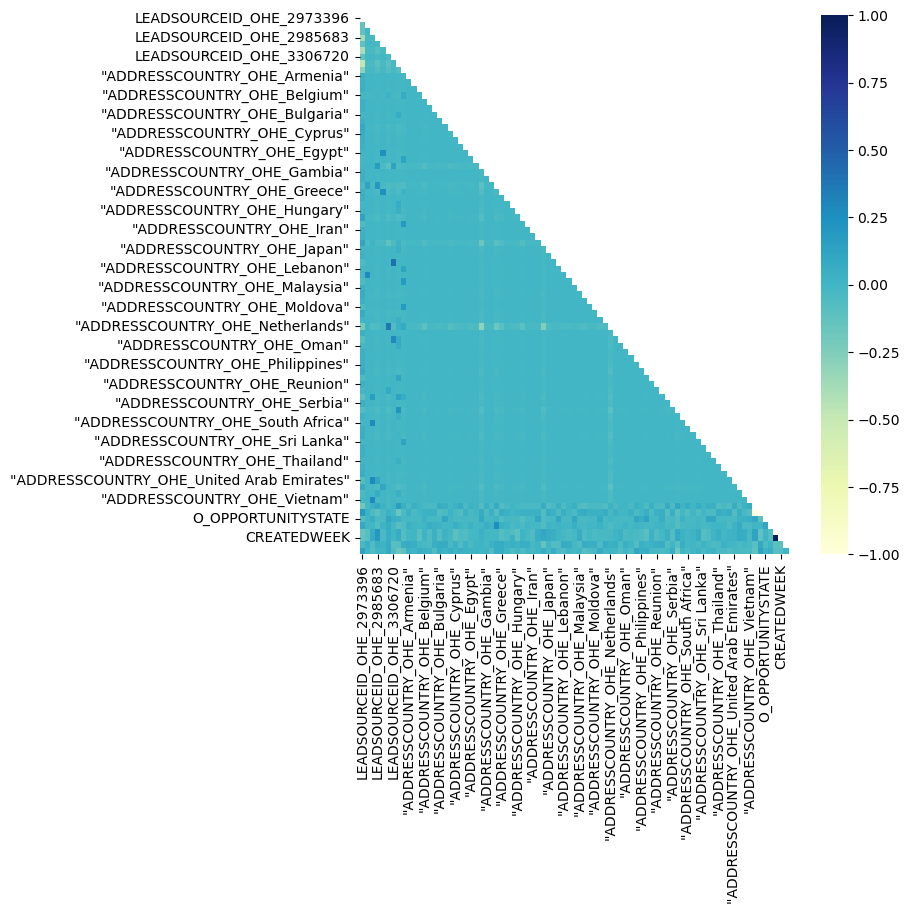

In [48]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_leads_df, dtype=bool))

# Create a heatmap with the features
plt.figure(figsize=(7, 7))
heatmap = sns.heatmap(corr_leads_df, mask=mask, cmap="YlGnBu", annot=False, vmin=-1, vmax=1)

In [ ]:
# Set up a plot to look at LEADSOURCEID and O_OPPORTUNITYSTATE
counts = transformed_leads_df.to_pandas().groupby(['LEADSOURCEID', 'O_OPPORTUNITYSTATE']).size().reset_index(name='Count')

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.scatterplot(data=counts, x='O_OPPORTUNITYSTATE', y='LEADSOURCEID', size='Count', markers='o', alpha=(0.1, .25, 0.5, 0.75, 1))
ax.grid(axis='y')

# The relationship is not linear - it appears exponential which makes sense given the rarity of the large diamonds
sns.move_legend(ax, "upper left")
sns.despine(left=True, bottom=True)

In [ ]:
session.close()